## Challenge

**The scenario**

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset [see details here.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In this challenge, you are required to improve your model with respect to its prediction performance.

**Steps**

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. - But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set.Use k-f old cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

### 1. Load the houseprices data from Thinkful's database.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.model_selection  import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

### 2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. - But make sure that your work is satisfactory.

In [2]:
houses_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
#Looking for features with higher correlation with Price

correlation = houses_df.corr()
cor_target = abs(correlation["saleprice"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features.sort_values(ascending=False)


saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
yearremodadd    0.507101
Name: saleprice, dtype: float64

In [4]:
#One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other

highcorrelation = houses_df[list(relevant_features.index)].corr()
tobeconsider = highcorrelation[highcorrelation > 0.59]
tobeconsider


,overallqual,yearbuilt,yearremodadd,totalbsmtsf,firstflrsf,grlivarea,fullbath,totrmsabvgrd,garagecars,garagearea,saleprice
overallqual,1.000000,NaN,NaN,NaN,NaN,0.593007,NaN,NaN,0.600671,NaN,0.790982
yearbuilt,NaN,1.000000,0.592855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearremodadd,NaN,0.592855,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totalbsmtsf,NaN,NaN,NaN,1.000000,0.819530,NaN,NaN,NaN,NaN,NaN,0.613581
firstflrsf,NaN,NaN,NaN,0.819530,1.000000,NaN,NaN,NaN,NaN,NaN,0.605852
grlivarea,0.593007,NaN,NaN,NaN,NaN,1.000000,0.630012,0.825489,NaN,NaN,0.708624
fullbath,NaN,NaN,NaN,NaN,NaN,0.630012,1.000000,NaN,NaN,NaN,NaN
totrmsabvgrd,NaN,NaN,NaN,NaN,NaN,0.825489,NaN,1.000000,NaN,NaN,NaN
garagecars,0.600671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.882475,0.640409
garagearea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882475,1.000000,0.623431


#### Based on numbers above I decided to:

- Include these features: overallqual,grlivarea, yearbuil, garagecars, totalsf and fullbath

- Because between _totrmsabvgrd_ and _grlivarea_ there is a high correlation, I would consider to take _grlivarea_

- Because between _yearbuild_ and _yearremodadd_ there is a high correlation, I would consider to take _yearbuild_

- Because between _garagearea_ and _garagecars_ there is a high correlation, I would consider to take _garagecars_

- There will be a new feature _totalsf_ as a result of the sum of _totalbsmtsf_ and _firstflrsf_


#### Let's analize categorical variables

In [5]:
#Finding categorical variables

categorical = []
for column in houses_df.columns:
    if len(houses_df[column].unique()) < 20:
        categorical.append(column)


In [6]:
#Creating functions to be used below

import scipy.stats as stats

def drawbarplot(categorical,target):

    '''
    This function take a list of variables and create a barplot related to the target
    arguments: a list of categorical variables
    returns: none
    '''
    
    i=0
    title = 'Average of ' + str(target)
    
    while i < len(categorical):

        plt.figure(figsize=(18,5))

        plt.subplot(1,3,1)
        sns.barplot(houses_df[categorical[i]], houses_df[target])
        plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title(title)

        if i+1 < len(categorical):
            plt.subplot(1,3,2)
            sns.barplot(houses_df[categorical[i+1]], houses_df[target])
            plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
            plt.title(title)

        if i+2 < len(categorical):

            plt.subplot(1,3,3)
            sns.barplot(houses_df[categorical[i+2]], houses_df[target])
            plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
            plt.title(title)

        plt.show()

        i+=3

        

def verifystatdifferences(catvariables,target):

    '''
        Function that return the results of stats.ttest_ind (Test whether group differences are significant). This is 
        a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values.
        Arguments: List of categorical variables and the target
        Returns: results of stats.ttest_ind
    '''
    
    for categoricalvar in catvariables:

        values = houses_df[categoricalvar].unique()
        grouped_df = houses_df[categoricalvar]

        print("------------------------------------------------")
        print("Comparisons for variables: {} and {}".format(target,categoricalvar))
        print("------------------------------------------------")
        for i in range(0, len(values)):
            for j in range(i+1, len(values)):
                print("t-test between groups {0} and {1}:".format(values[i], values[j]))
                print(stats.ttest_ind(
                    houses_df[houses_df[categoricalvar]==values[i]][target], 
                    houses_df[houses_df[categoricalvar]==values[j]][target]
                ))



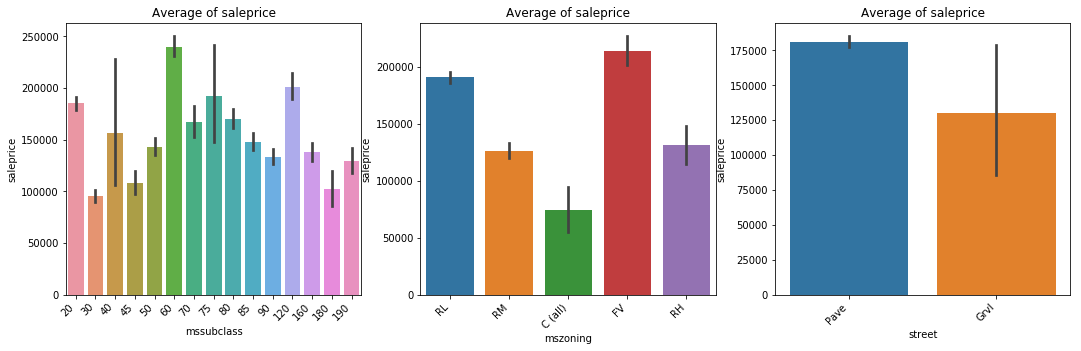

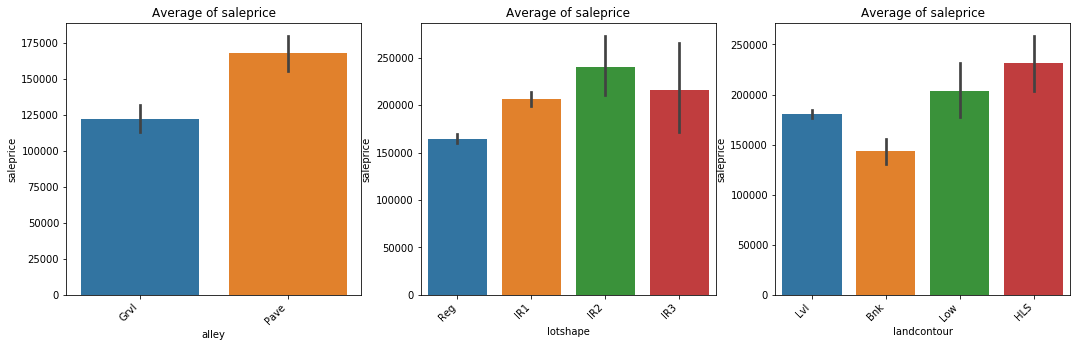

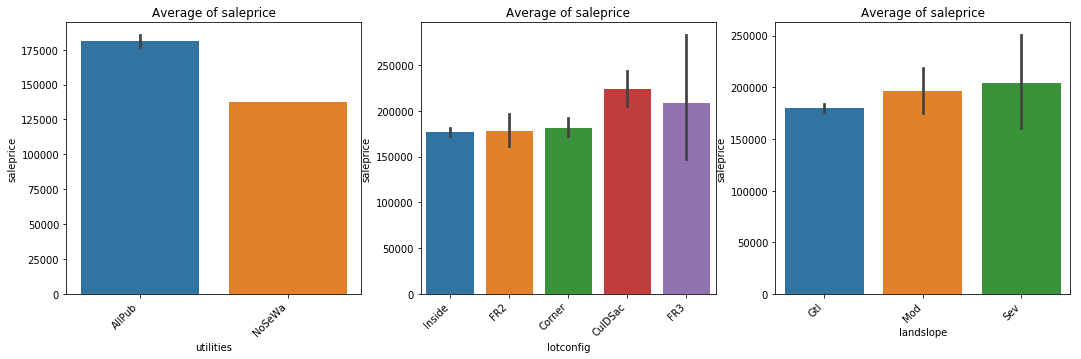

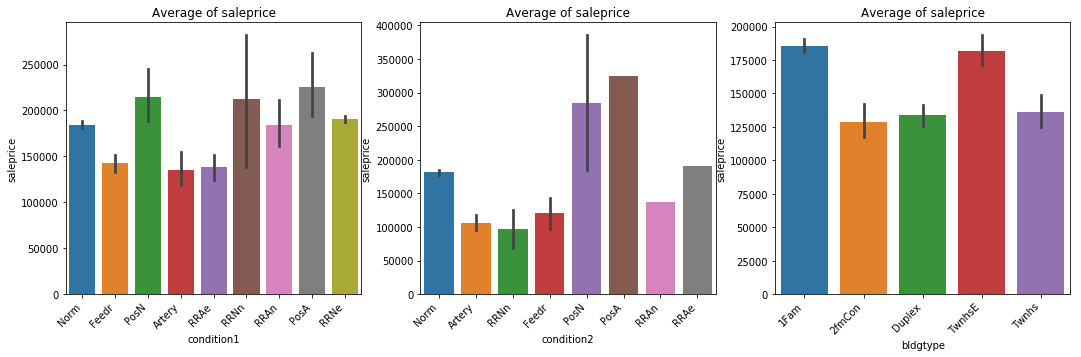

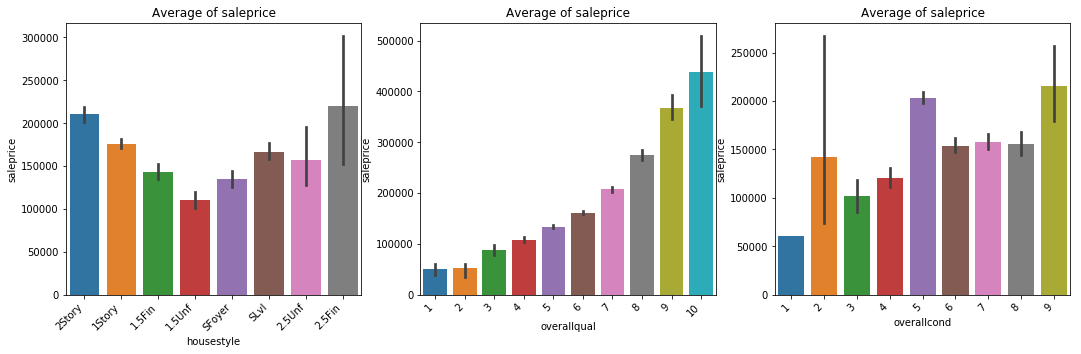

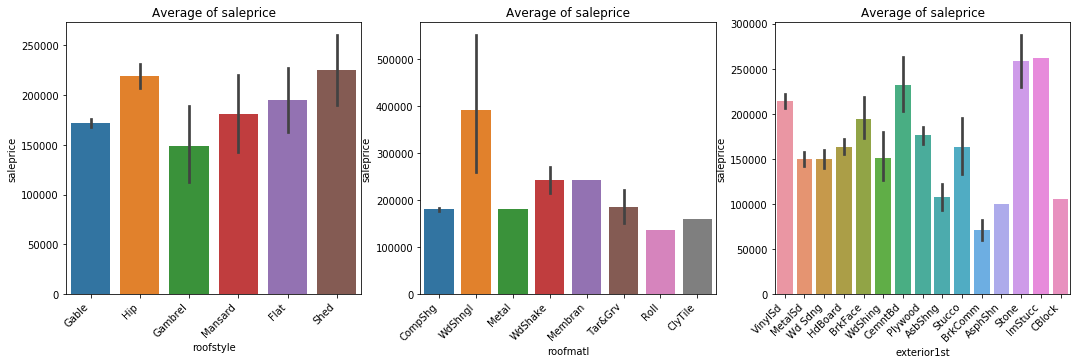

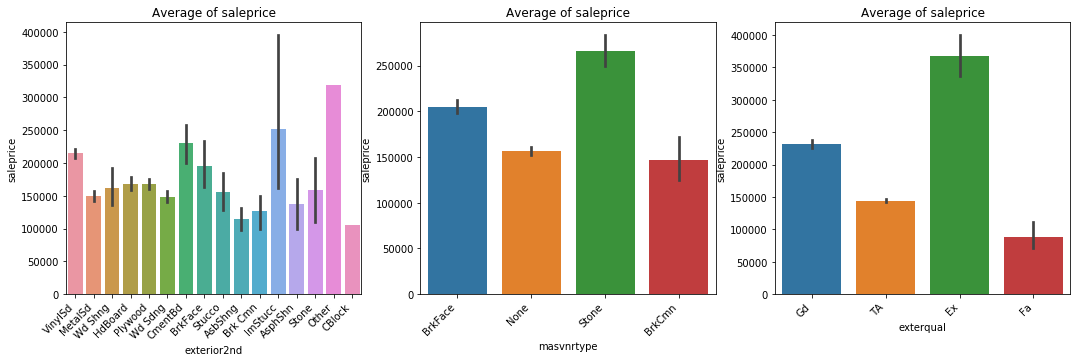

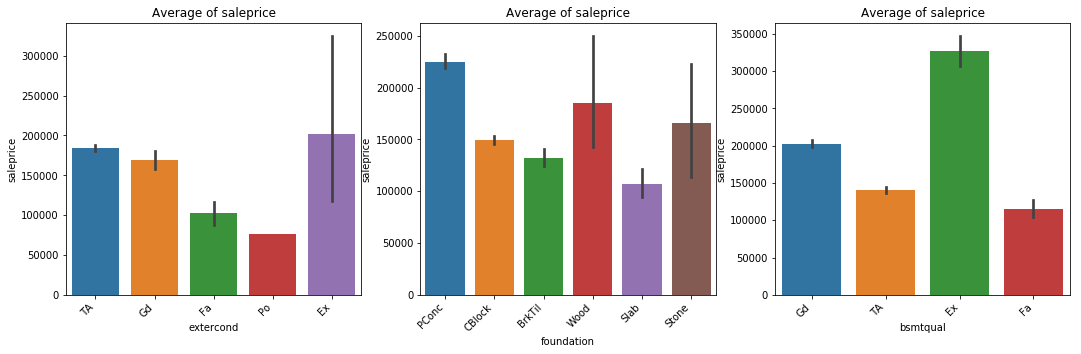

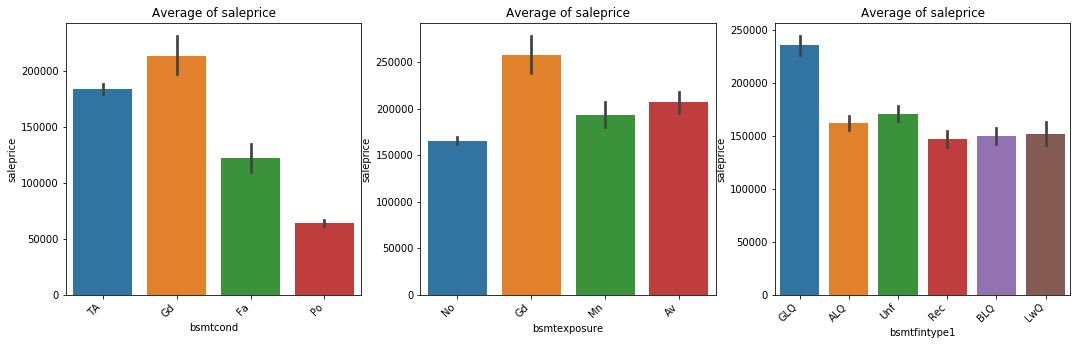

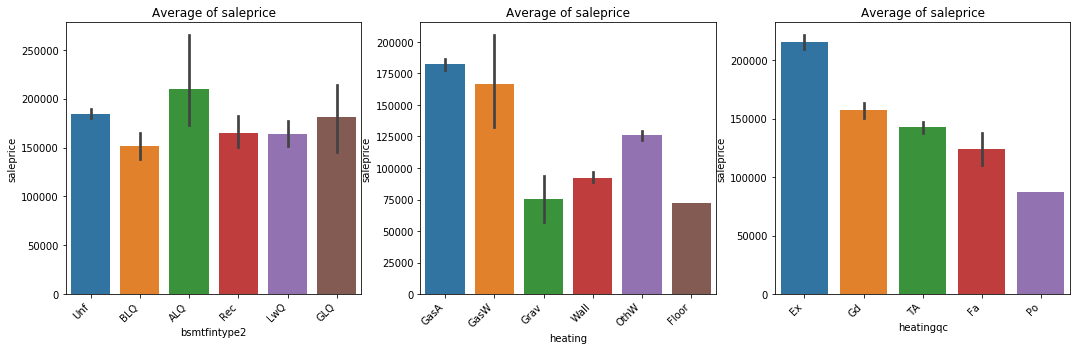

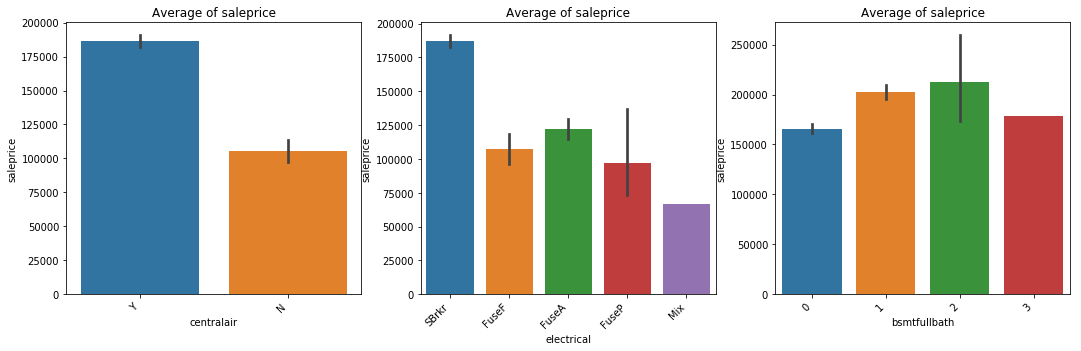

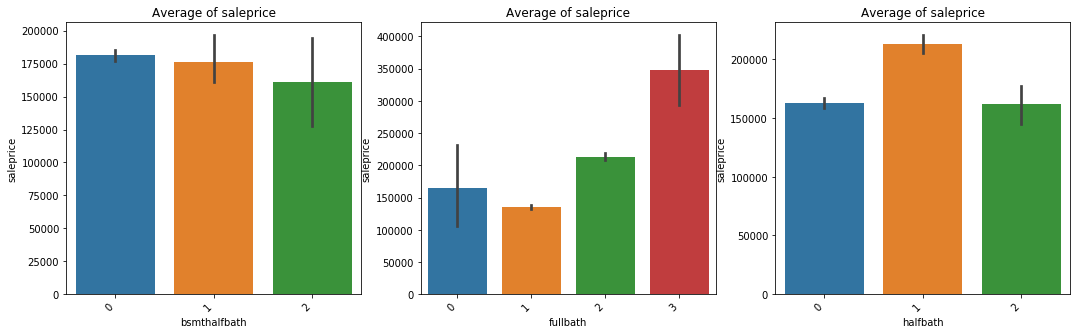

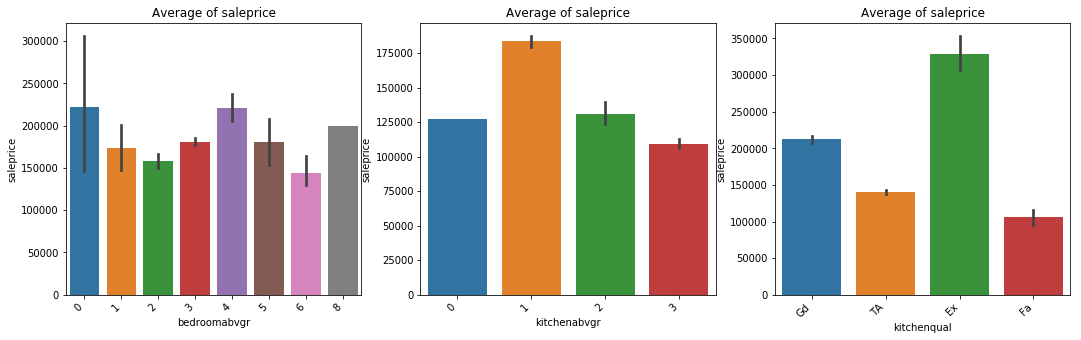

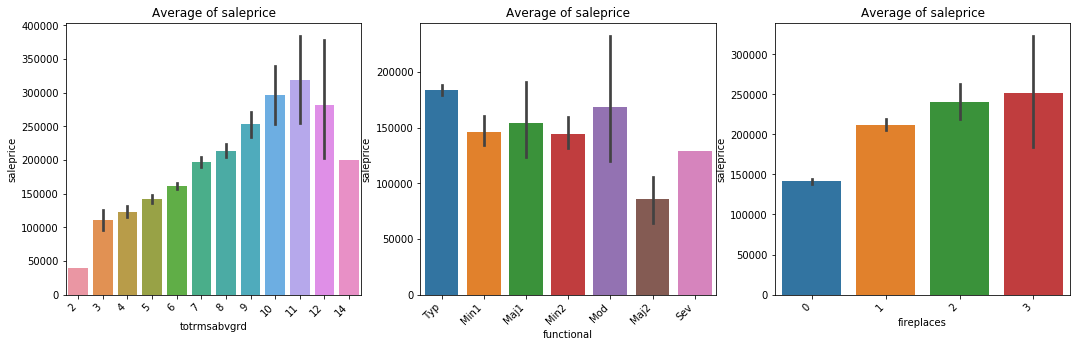

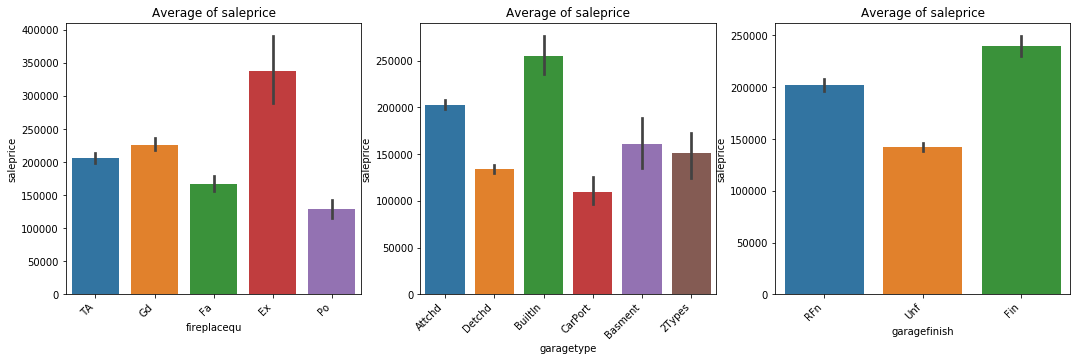

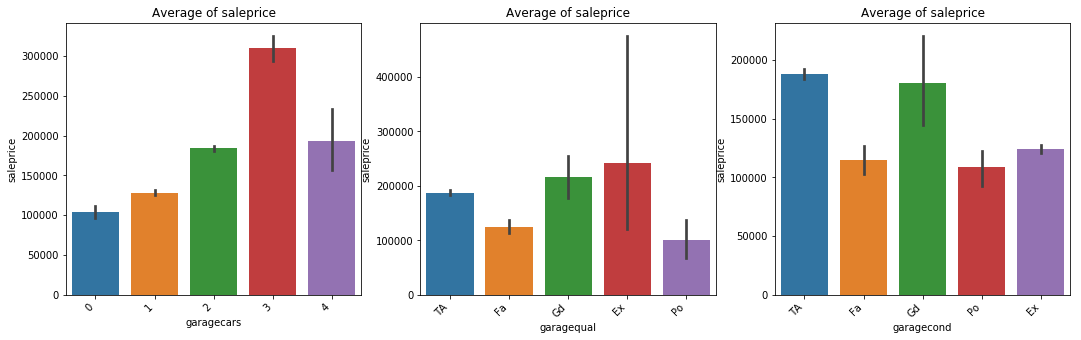

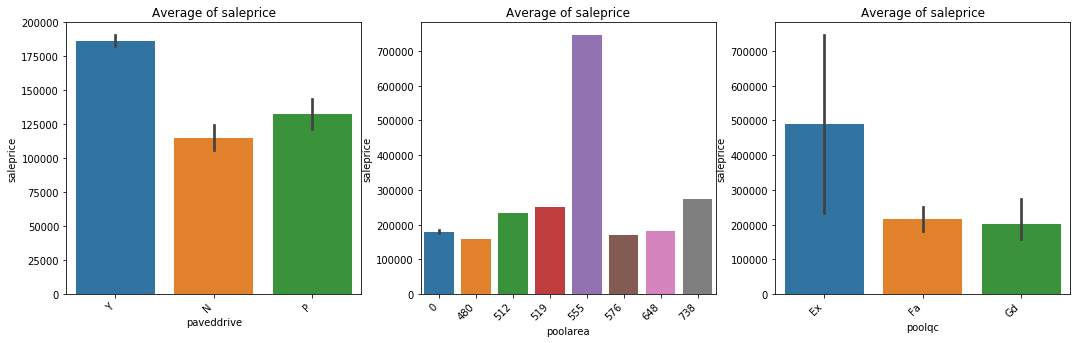

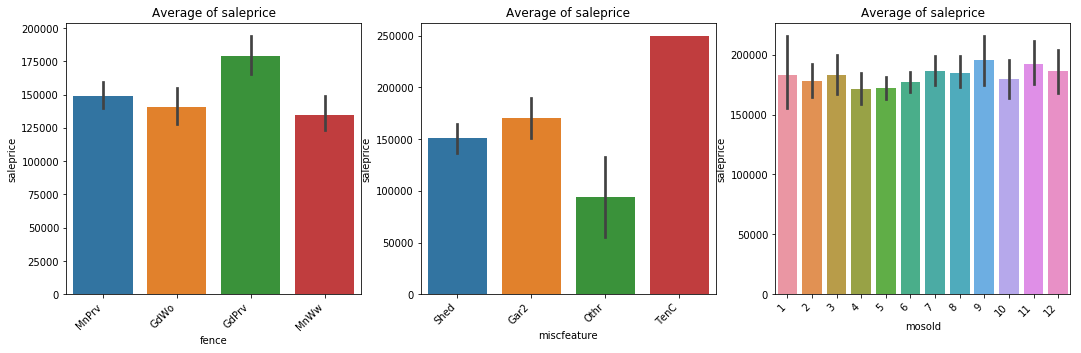

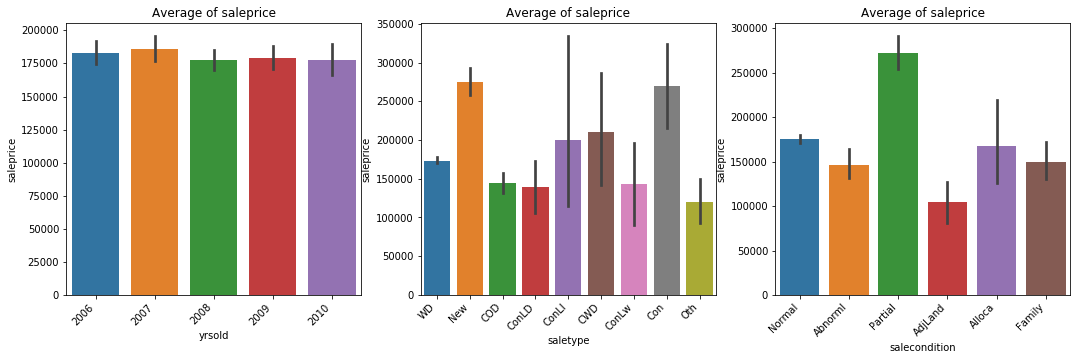

In [7]:
#Calling function to visualize barplots
drawbarplot(categorical,'saleprice')

#### Based on visualizations above I'm considering these features:
_mszoning_, _street_, _exterqual_,_heatingqc_ , _extercond_ and _kitchenequal_

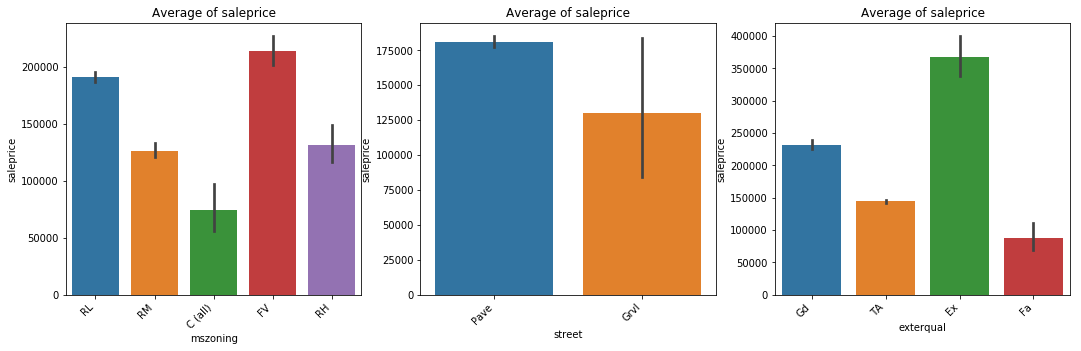

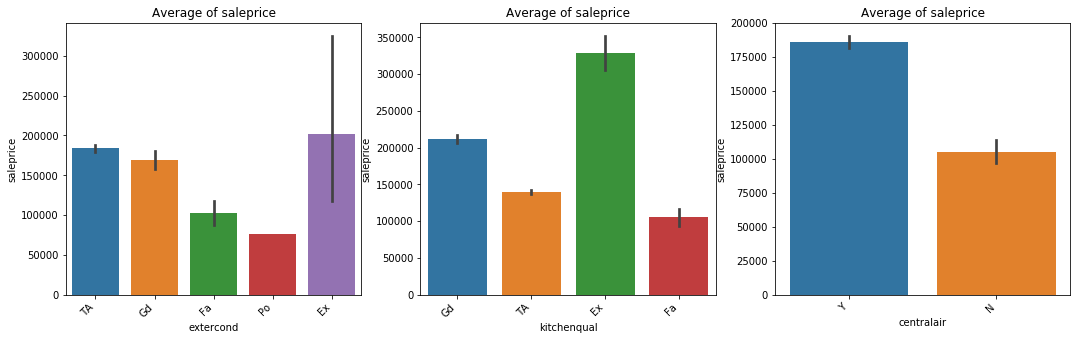

In [8]:
#Bar plot for selected categorical variables

selectedcategorical = ['mszoning', 'street', 'exterqual', 'extercond' ,'kitchenqual','centralair']
drawbarplot(selectedcategorical,'saleprice')    

#### Let's verify if these deatures are statistically significant 

In [9]:
#Calling verifystatdifferences

verifystatdifferences(selectedcategorical,'saleprice')

------------------------------------------------
Comparisons for variables: saleprice and mszoning
------------------------------------------------
t-test between groups RL and RM:
Ttest_indResult(statistic=11.438976301048546, pvalue=5.31147433276907e-29)
t-test between groups RL and C (all):
Ttest_indResult(statistic=4.5554032850378485, pvalue=5.781371468431197e-06)
t-test between groups RL and FV:
Ttest_indResult(statistic=-2.2695213034922688, pvalue=0.023411437975482768)
t-test between groups RL and RH:
Ttest_indResult(statistic=2.9391375423118626, pvalue=0.0033561549774499266)
t-test between groups RM and C (all):
Ttest_indResult(statistic=3.334731251556495, pvalue=0.000997822737851211)
t-test between groups RM and FV:
Ttest_indResult(statistic=-12.555550172791989, pvalue=5.290552561341391e-29)
t-test between groups RM and RH:
Ttest_indResult(statistic=-0.42338400546928706, pvalue=0.6724073389418611)
t-test between groups C (all) and FV:
Ttest_indResult(statistic=-8.139418517089082

**Since most of the  p-values are less than 0.05 or 0.1, I decided to take all those categorical variables**

In [10]:
#Get dummies for non numeric categorical variables and adding to dataframe
#Dummies for: mszoning, street, exterqual, extercond and kitchenqual

dummy_column_names = []
for varcat in selectedcategorical:
    
    dropFirst = False
    
    if(len(houses_df[varcat].unique()) == 2):
        dropFirst = True
      
    houses_df = pd.concat([houses_df,pd.get_dummies(houses_df[varcat], prefix=varcat, drop_first=dropFirst)], axis=1)
    dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_df[varcat], prefix=varcat, drop_first=dropFirst).columns)
    


In [11]:
houses_df['mszoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [12]:
dummy_column_names

['mszoning_C (all)',
 'mszoning_FV',
 'mszoning_RH',
 'mszoning_RL',
 'mszoning_RM',
 'street_Pave',
 'exterqual_Ex',
 'exterqual_Fa',
 'exterqual_Gd',
 'exterqual_TA',
 'extercond_Ex',
 'extercond_Fa',
 'extercond_Gd',
 'extercond_Po',
 'extercond_TA',
 'kitchenqual_Ex',
 'kitchenqual_Fa',
 'kitchenqual_Gd',
 'kitchenqual_TA',
 'centralair_Y']

In [13]:
['overallqual','grlivarea', 'yearbuilt', 'garagecars', 'totalsf', 'fullbath']

['mszoning', 'street', 'exterqual', 'extercond' ,'kitchenqual']

['mszoning', 'street', 'exterqual', 'extercond', 'kitchenqual']

#### Cleaning selected features

All null values are in yellow


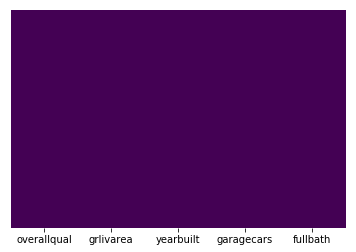

In [14]:
#Searching missing values

print('All null values are in yellow')
sns.heatmap(houses_df[['overallqual','grlivarea', 'yearbuilt', 'garagecars','fullbath']].isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Cleaning outliers

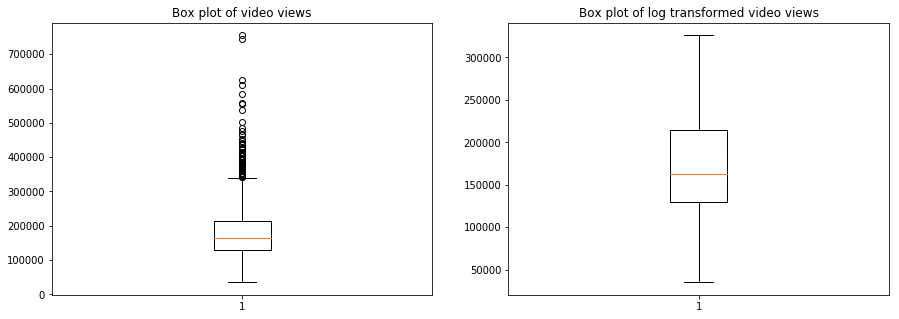

In [15]:
from scipy.stats.mstats import winsorize

winsorized_views = winsorize(houses_df['saleprice'], (0, 0.05))

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(houses_df['saleprice'])
plt.title("Box plot of video views")

plt.subplot(1,2,2)
plt.boxplot(winsorize(houses_df['saleprice'], (0, 0.05)))
plt.title("Box plot of log transformed video views")
plt.show()

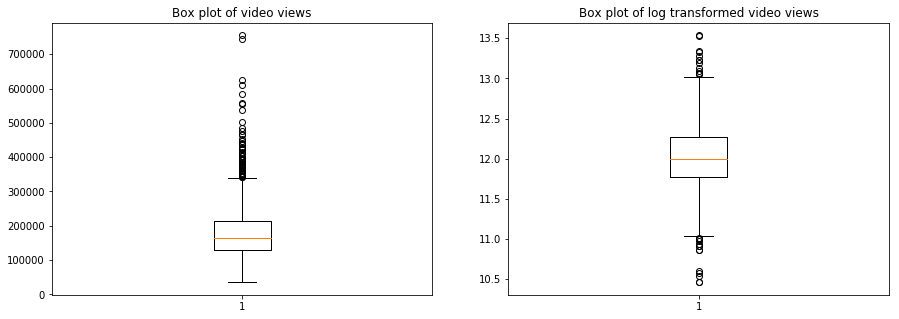

In [16]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(houses_df['saleprice'])
plt.title("Box plot of video views")

plt.subplot(1,2,2)
plt.boxplot(np.log(houses_df['saleprice']))
plt.title("Box plot of log transformed video views")
plt.show()

#### Based on visualizations, I decided to apply winsorize technique to handle outliers

In [17]:
houses_df['winsorized_saleprice'] = winsorize(houses_df['saleprice'], (0, 0.05))

#### Set X and Y variables of the model

In [18]:
#Creating a interaction feature with two related variables
houses_df['totalsf'] = houses_df['totalbsmtsf'] + houses_df['firstflrsf'] 

#Creating feature set for X
X = houses_df[['overallqual','grlivarea', 'yearbuilt', 'garagecars', 'totalsf', 'fullbath','totalsf'] + dummy_column_names]

# Y is the target variable
Y = houses_df['winsorized_saleprice']

# Adding a constant
# in statsmodels' sm
X = sm.add_constant(X)

### 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=101)

### 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set.Use k-fold cross-validation to select the best hyperparameters if your models include one!


In [20]:
#Model 1 - OLS

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_test = lrm.predict(X_test)
accuracy=cross_val_score(lrm, X_train, y_train, cv=5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))


R-squared of the model in the training set is: 0.8438635698839726
-----Test set statistics-----
R-squared of the model in the test set is: 0.7680160275140575
Mean absolute error of the prediction is: 19995.151761812467
Mean squared error of the prediction is: 1145697879.5768611
Root mean squared error of the prediction is: 33848.15917560158
Mean absolute percentage error of the prediction is: 11.860760398034847
Accuracy: 0.835 (+/- 0.043)


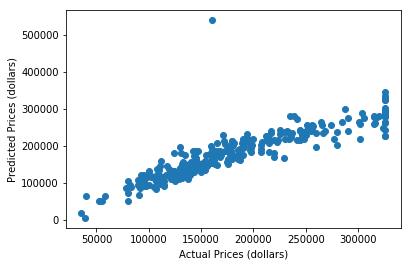

In [21]:
plt.scatter(y_test,y_preds_test)
plt.xlabel('Actual Prices (dollars)')
plt.ylabel('Predicted Prices (dollars)')
plt.show()

In [22]:
#Model 2 - Ridge

from sklearn.linear_model import RidgeCV

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

ridgeregr = RidgeCV(alphas=alphas) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_test = ridgeregr.predict(X_test)


#do k-fold cross-validation
accuracy=cross_val_score(ridgeregr, X_train, y_train, cv=5)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model on the training set is: 0.8429433739832011
-----Test set statistics-----
R-squared of the model on the test set is: 0.7684477781174741
Mean absolute error of the prediction is: 19964.18758642185
Mean squared error of the prediction is: 1143565595.4128313
Root mean squared error of the prediction is: 33816.64672040726
Mean absolute percentage error of the prediction is: 11.840035891587577
Accuracy: 0.836 (+/- 0.043)


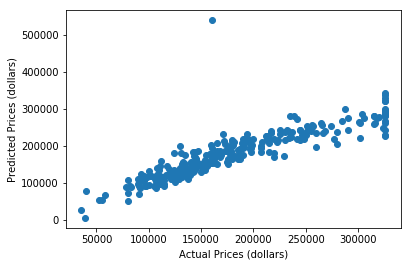

In [23]:
plt.scatter(y_test,y_preds_test)
plt.xlabel('Actual Prices (dollars)')
plt.ylabel('Predicted Prices (dollars)')
plt.show()

In [24]:
#Model 3- ElasticNet

elasticregr = ElasticNetCV(alphas=alphas, cv=5)
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_test = elasticregr.predict(X_test)

#do k-fold cross-validation
accuracy=cross_val_score(elasticregr, X_train, y_train, cv=5)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model on the training set is: 0.8432869891026596
-----Test set statistics-----
R-squared of the model on the test set is: 0.7686287362207043
Mean absolute error of the prediction is: 19960.481818227392
Mean squared error of the prediction is: 1142671898.6934352
Root mean squared error of the prediction is: 33803.430279979504
Mean absolute percentage error of the prediction is: 11.841506888722739
Accuracy: 0.836 (+/- 0.042)


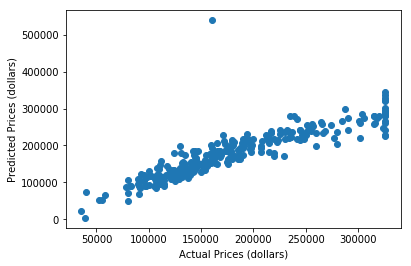

In [25]:
plt.scatter(y_test,y_preds_test)
plt.xlabel('Actual Prices (dollars)')
plt.ylabel('Predicted Prices (dollars)')
plt.show()

In [26]:
#Model 4 - Lasso 

lassoregr = LassoCV(alphas=alphas, cv=5)
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_test = lassoregr.predict(X_test)

#do k-fold cross-validation
accuracy=cross_val_score(lassoregr, X_train, y_train, cv=5)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model on the training set is: 0.8420458466827727
-----Test set statistics-----
R-squared of the model on the test set is: 0.7695396316928093
Mean absolute error of the prediction is: 19972.121831612956
Mean squared error of the prediction is: 1138173264.586418
Root mean squared error of the prediction is: 33736.82356989789
Mean absolute percentage error of the prediction is: 11.864984126286187
Accuracy: 0.835 (+/- 0.043)


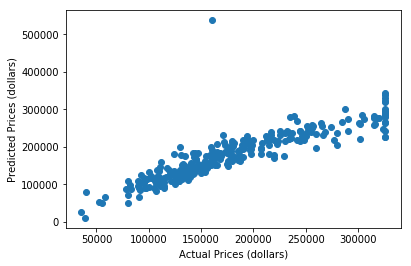

In [27]:
plt.scatter(y_test,y_preds_test)
plt.xlabel('Actual Prices (dollars)')
plt.ylabel('Predicted Prices (dollars)')
plt.show()

### 5. Evaluate your best model on the test set

In [28]:
#Model 1 - OLS

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8438635698839726
-----Test set statistics-----
R-squared of the model in the test set is: 0.7680160275140575
Mean absolute error of the prediction is: 19995.151761812467
Mean squared error of the prediction is: 1145697879.5768611
Root mean squared error of the prediction is: 33848.15917560158
Mean absolute percentage error of the prediction is: 11.860760398034847
Accuracy: 0.835 (+/- 0.043)


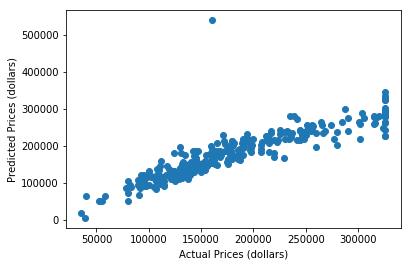

In [29]:
plt.scatter(y_test,y_preds_test)
plt.xlabel('Actual Prices (dollars)')
plt.ylabel('Predicted Prices (dollars)')
plt.show()

In [30]:
houses_df[houses_df['saleprice']>699999]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,extercond_Gd,extercond_Po,extercond_TA,kitchenqual_Ex,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,centralair_Y,winsorized_saleprice,totalsf
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,0,1,1,0,0,0,1,326000,4888
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,0,0,1,1,0,0,0,1,326000,4807


### 6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [31]:
# Creating a new data frame with interest rates per year per state
# Source: Federal Housing Finance agency
# https://www.fhfa.gov/DataTools/Downloads/Pages/Monthly-Interest-Rate-Data.aspx

interest_df = pd.read_csv('interest_rate.csv')
interest_df.head()

,State,Year,Contract_interest_rate,Initial_interest_rate,Effective_interest_rate,term_to_maturity,purchase_price,loan_to_price_ratio,Adj_rate_loans,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,Alabama,1978,9.40,2.26,9.78,27.50,53.40,79.10,N/A*,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,1979,10.53,2.04,10.89,27.50,60.70,77.00,N/A*,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,1980,11.94,2.26,12.36,28.50,69.70,75.70,N/A*,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,1981,13.21,2.82,13.77,28.90,59.60,82.50,N/A*,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,1982,14.21,2.10,14.64,28.90,53.00,86.20,N/A*,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#Filling interest rate column

def get_interest_rate(years):
   
    interest = float(pd.to_numeric(interest_df[(interest_df['Year']==str(years))& (interest_df['State']=='Iowa')]['Effective_interest_rate'], downcast="float"))
    return interest  
  

houses_df['interest_rate'] = houses_df.yrsold.apply(get_interest_rate) 


In [33]:
#Creating a model with new variable

#Creating a interaction feature with two related variables
houses_df['totalsf'] = houses_df['totalbsmtsf'] + houses_df['firstflrsf'] 

#Creating feature set for X
X = houses_df[['overallqual','grlivarea', 'yearbuilt', 'garagecars', 'totalsf', 'fullbath','totalsf','interest_rate'] + dummy_column_names]

# Y is the target variable
Y = houses_df['saleprice']

# Adding a constant
# in statsmodels' sm
X = sm.add_constant(X)


In [34]:
#Model 1 - OLS

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_test = lrm.predict(X_test)
accuracy=cross_val_score(lrm, X_train, y_train, cv=5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8438635698839726
-----Test set statistics-----
R-squared of the model in the test set is: 0.7680160275140575
Mean absolute error of the prediction is: 19995.151761812467
Mean squared error of the prediction is: 1145697879.5768611
Root mean squared error of the prediction is: 33848.15917560158
Mean absolute percentage error of the prediction is: 11.860760398034847
Accuracy: 0.835 (+/- 0.043)


**No implications for adding a new variable**

----------------------------------------------------------

By: Wendy Navarrete

08/19/2019